## Import Airport Dataset and create distance function

In [1]:
import pandas
pandas.options.display.float_format = '{:.1f}'.format
import datetime

In [2]:
# READ IN THE AIRPORT CSV FILE
airport_path = "../data/airport_LL.csv"
airports = pandas.read_csv(airport_path)
del airports['Unnamed: 17']
del airports['Unnamed: 18']
del airports['Unnamed: 19']

In [3]:
import math

cRadiusOfEarthMi = 3963.34

def rad_theta(row):
    rad_theta = -1 if ((row['Longitude_EW']) == "E") else 1
    rad_theta = (rad_theta*row['Longitude_deg']+row['Longitude_min']/60+row['Longitude_sec']/360)*math.pi/180
    return rad_theta
    
airports['rad_theta'] = airports.apply (lambda row: rad_theta(row), axis=1)

def rad_phi(row):
    rad_phi = -1 if ((row['Latitude_NS']) == "N") else 1
    rad_phi = (rad_phi*(row['Latitude_deg']+row['Latitude_min']/60+row['Latitude_sec']/360))*math.pi/180
    return rad_phi
    
airports['rad_phi'] = airports.apply (lambda row: rad_phi(row), axis=1)


In [4]:
airports['XYZ'] = airports.apply (lambda row: \
         [(cRadiusOfEarthMi*math.cos(row['rad_phi'])*math.cos(row['rad_theta'])),   
        (cRadiusOfEarthMi*math.cos(row['rad_phi'])*math.sin(row['rad_theta'])),
         (cRadiusOfEarthMi*math.sin(row['rad_phi']))], axis=1  )   

In [5]:
# CALCULATE DISTANCE FOR OD PAIRS

def ODdistance(ORIG, DEST):
    ORIGxyz = airports.loc[airports['Airport Code']==ORIG]['XYZ']
    DESTxyz = airports.loc[airports['Airport Code']==DEST]['XYZ']
    Z =math.sqrt(sum([(a - b)*(a - b) for a, b in zip(ORIGxyz.iloc[0], DESTxyz.iloc[0])]))
    Y = 2 * math.asin(Z/(2*cRadiusOfEarthMi)) * cRadiusOfEarthMi
    return Y


## Process data file

In [6]:
# READ IN THE FLIGHT LOG FILE
fl_path = "../data/SamFlightLog.xlsx"
flightlog_xl = pandas.ExcelFile(fl_path)
flightlog = flightlog_xl.parse('Log')

In [7]:
# COMPUTE AIRPORT PAIR
flightlog['ODvector'] = flightlog.apply (lambda row: row['Origin']+"-"+row['Destination'],axis=1)

In [8]:
def ODpair(row):
    if (row['Origin'])>(row['Destination']):
        return row['Origin']+"-"+row['Destination']
    else:
        return row['Destination']+"-"+row['Origin']
        
flightlog['ODpair'] = flightlog.apply (lambda row: ODpair(row),axis=1)

In [9]:
flightlog['ODDistance'] = flightlog.apply (lambda row: ODdistance(row['Origin'],row['Destination']),axis=1)

In [10]:
flightlog['YearMonth'] = flightlog['Date'].map(lambda x: 100*x.year + x.month)
flightlog['countone'] = 1

In [11]:
flightlog['YearMonthDay'] = flightlog['Date'].map(lambda x: 10000*x.year + x.month*100+x.day)

In [12]:
flightlog.to_csv('..\DataOut\logout.csv')

## Basic Descriptives

In [13]:
pairflights =  flightlog.groupby(['ODpair'])['ODDistance'] \
    .agg(['sum','count']) 
pairflights.columns = ['TotalMilesFlown','NumberOfFlights']
pairflights['AvgMilesPerFlight'] = pairflights['TotalMilesFlown']/pairflights['NumberOfFlights']

In [14]:
pairflights['ODName'] = pairflights.index.values

In [15]:
pairflights.sort_values(by=['TotalMilesFlown'],ascending=False,inplace=True)

In [16]:
topFlights = pairflights.iloc[0:30,:]
topflightlist = topFlights['ODName'].tolist()

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

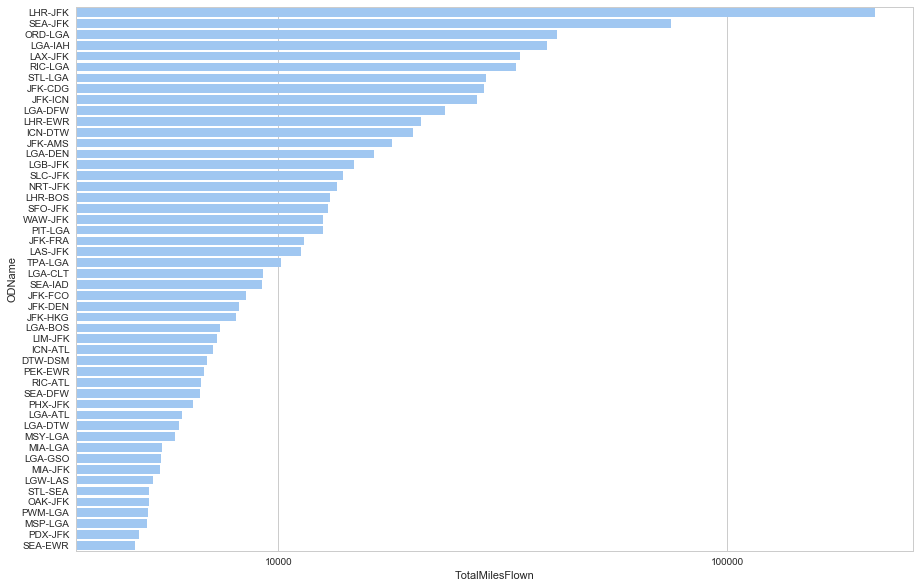

In [18]:

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))


ax.set_xscale('log',basex=10)

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x='TotalMilesFlown', y='ODName', data=pairflights
            .sort_values(by=['TotalMilesFlown'],ascending=False).iloc[0:50,:],
            label="Total Miles Flown", color="b")
plt.show()


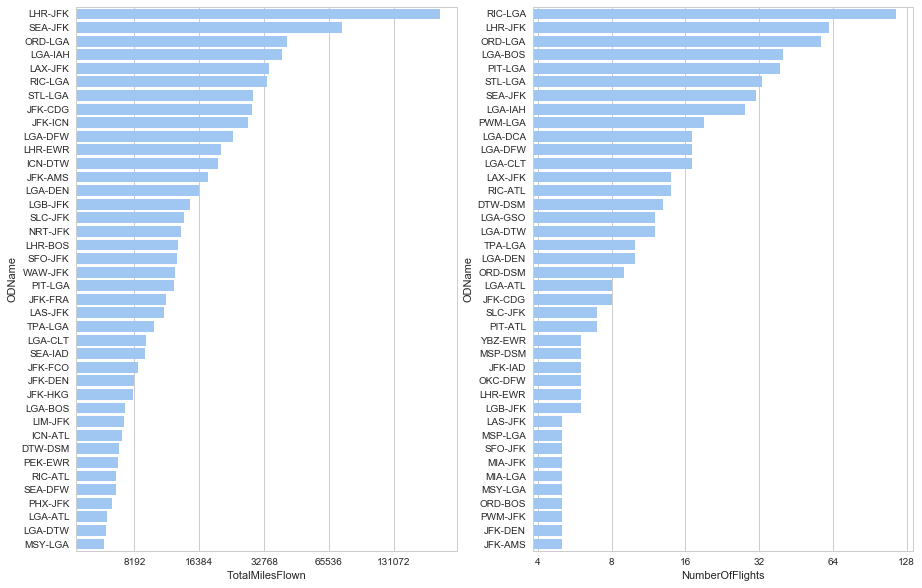

In [19]:
# Initialize the matplotlib figure
f, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15, 10))

for axA in (ax1,ax2):
    axA.set_xscale('log',basex=2)
    axA.xaxis.set_major_formatter(formatter)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x='TotalMilesFlown', y='ODName', 
            data=pairflights.sort_values(by=['TotalMilesFlown'],ascending=False).iloc[0:40,:],label="Total Miles Flown", 
            color="b", ax=ax1)
sns.barplot(x='NumberOfFlights', y='ODName', 
            data=pairflights.sort_values(by=['NumberOfFlights'],ascending=False).iloc[0:40,:],
            label="Number Of Flights", color="b", ax=ax2)
plt.show()

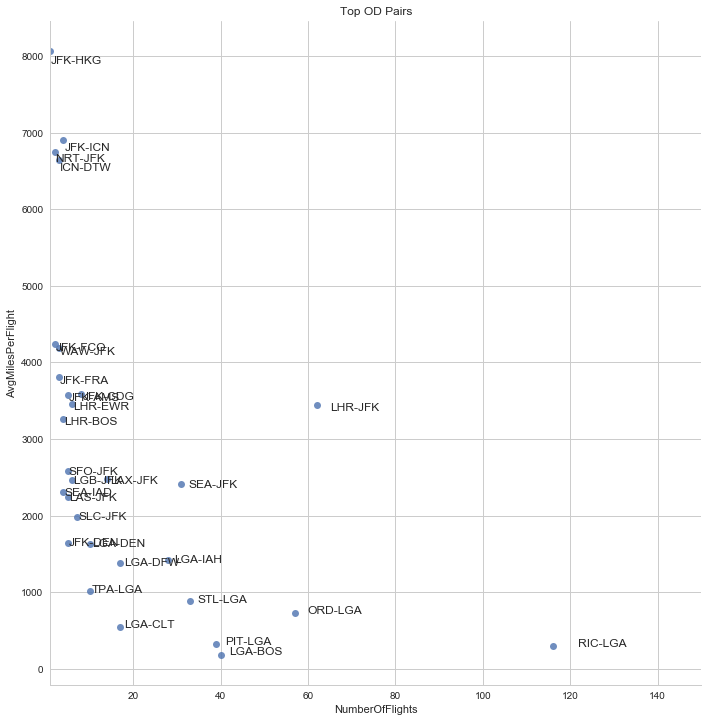

In [20]:
ax = sns.lmplot('NumberOfFlights', # Horizontal axis
           'AvgMilesPerFlight', # Vertical axis
           data=topFlights, # Data source
           fit_reg=False, # Don't fix a regression line
           size = 10,
           aspect =1 ) # size and dimension

plt.title('Top OD Pairs')
# Set x-axis label
plt.xlabel('NumberOfFlights')
#plt.xscale('log')
plt.xlim(1,150)
# Set y-axis label
plt.ylabel('AvgMilesPerFlight')
#plt.yscale('log')


def label_point(x, y, val, ax):
    a = pandas.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']*1.05, point['y']*0.98, str(point['val']))

label_point(topFlights.NumberOfFlights, topFlights.AvgMilesPerFlight, topFlights.ODName, plt.gca()) 

## Create time series by OD Pair

In [21]:
mileseries = pandas.crosstab(flightlog.Date, flightlog.ODpair,
                    values=flightlog.ODDistance, aggfunc=sum).fillna(0).cumsum()
mileseries = mileseries.reset_index()
#mileseries = mileseries.replace(0, np.nan)
# , margins='true'

In [22]:
miletotals = pandas.crosstab(flightlog.Date,1,values=flightlog.ODDistance, aggfunc=sum).fillna(0).cumsum()

In [23]:
import matplotlib.style as style
#style.available

In [24]:
### NEED TO create array of all months between beginning and end of mileseries['YearMonth'] and then insert all those months

In [25]:
maxindex = mileseries['Date'].count() 
print(maxindex)

839


In [26]:
#sns.set_palette(sns.color_palette("cubehelix",10))

sns.set_palette(sns.hls_palette(14, l=.3, s=.8))

In [27]:
#style.use('seaborn-bright')

a = len(sns.color_palette())

%matplotlib inline
timegraph =mileseries.plot(x = 'Date', y = topflightlist, figsize = (25,15),legend=True)
timegraph.set_yscale('log')
timegraph.set_ylim(1000,300000)
for i in range(len(topflightlist)):
    maxval = mileseries.loc[maxindex-1,topflightlist[i]]
    b = i%a
    timegraph.text(x = '2020-01-20', y = maxval*1.00, s = topflightlist[i], weight='normal',
                   color = sns.color_palette()[b])
    
for i in range(len(topflightlist)):
    for j in range(1, maxindex-1):
        maxval = mileseries.loc[j,topflightlist[i]]
        if not math.isnan(maxval) and maxval>1000: 
            b = i%a
            timegraph.text(x = mileseries['Date'][j] + datetime.timedelta(days=15), y = 1050, s = topflightlist[i], weight='normal',
                   color = sns.color_palette()[b])
            break

In [28]:
mileseries.head()

ODpair       Date  BOS-ATL  BUD-AMS  CLT-ATL  CLT-BOS  CVG-ATL  DCA-BOS  \
0      2005-01-07      0.0      0.0      0.0      0.0      0.0    399.3   
1      2005-01-09      0.0      0.0      0.0      0.0      0.0    399.3   
2      2005-02-25      0.0      0.0      0.0      0.0      0.0    399.3   
3      2005-03-02      0.0      0.0      0.0      0.0      0.0    399.3   
4      2005-05-23      0.0      0.0      0.0      0.0      0.0    399.3   

ODpair  DCA-CLT  DEN-ATL  DEN-BOS   ...     YVR-LAX  YVR-MSP  YVR-ORD  \
0           0.0      0.0      0.0   ...         0.0      0.0      0.0   
1           0.0      0.0      0.0   ...         0.0      0.0      0.0   
2           0.0      0.0      0.0   ...         0.0      0.0      0.0   
3           0.0      0.0      0.0   ...         0.0      0.0      0.0   
4           0.0      0.0      0.0   ...         0.0      0.0      0.0   

ODpair  YVR-YMX  YYZ-IAH  YYZ-LGA  YYZ-PHL  YYZ-YVR  ZNZ-DAR  ZNZ-JRO  
0           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4           0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 261 columns]

In [29]:

mileseries['Date'][2] + datetime.timedelta(days=1)

Timestamp('2005-02-26 00:00:00')